In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, r2_score, root_mean_squared_error

In [2]:
df = pd.read_csv("claims.csv")

In [3]:
df.head()

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,DIAGNOSIS,Amount Billed
0,1,25.0,F,11/2/2025,11/2/2025,"CYESIS LMP OCT,28TH 2024",16800.0
1,2,30.0,M,13/2/2025,13/2/2025,WAX IMPACTION,6300.0
2,3,35.0,M,13/2/2025,13/2/2025,"CYESIS LMP OCT,28TH 2024",6160.0
3,4,48.0,M,18/2/2025,18/2/2025,"TONSILITIS, ?OBSTRUCTIVE SLEEP APEANA",NaN
4,5,58.0,NaN,18/2/2025,18/2/2025,REFRACTIVE ERROR,8400.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient ID         388 non-null    int64  
 1   AGE                117 non-null    float64
 2   GENDER             384 non-null    object 
 3   DATE OF ENCOUNTER  388 non-null    object 
 4   DATE OF DISCHARGE  388 non-null    object 
 5   DIAGNOSIS          385 non-null    object 
 6   Amount Billed      197 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 21.3+ KB


In [5]:
df.isnull().sum().sort_values(ascending=False)

AGE                  271
Amount Billed        191
GENDER                 4
DIAGNOSIS              3
Patient ID             0
DATE OF ENCOUNTER      0
DATE OF DISCHARGE      0
dtype: int64

In [6]:
df.nunique().sort_values(ascending=False).head(40)

Patient ID           388
DATE OF DISCHARGE    334
DATE OF ENCOUNTER    255
DIAGNOSIS            205
Amount Billed        109
AGE                   48
GENDER                 2
dtype: int64

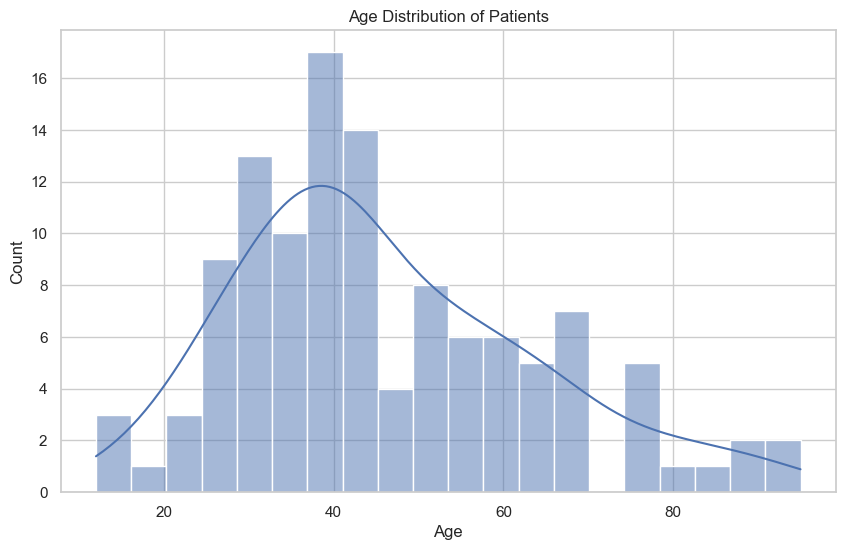

In [7]:
# Set plot style
sns.set(style="whitegrid")

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['AGE'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

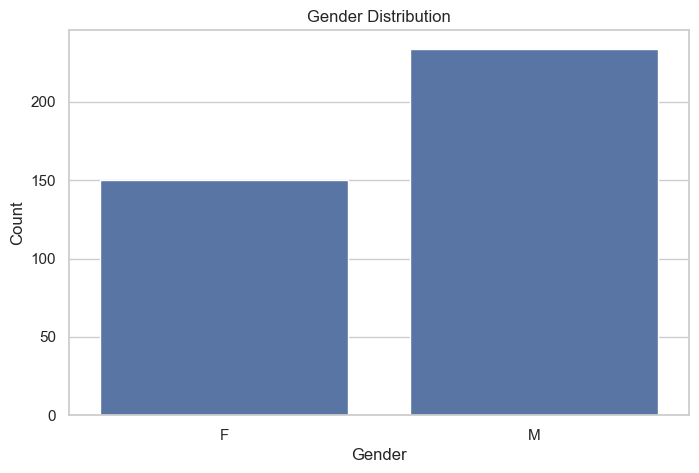

In [8]:
# Gender distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='GENDER', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

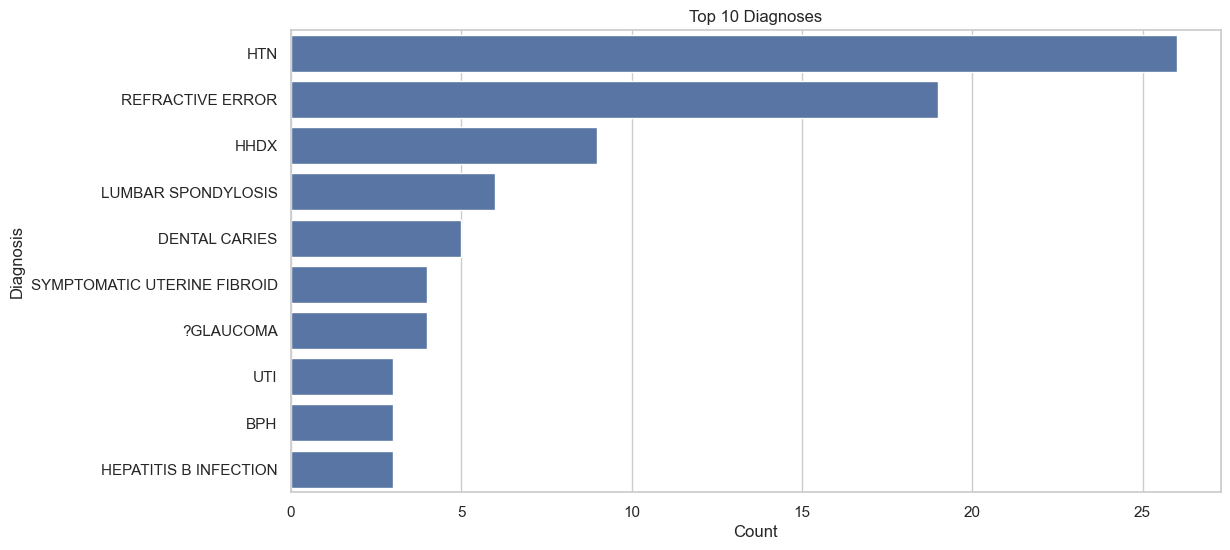

In [9]:
# Top 10 diagnoses
plt.figure(figsize=(12, 6))
top_diagnoses = df['DIAGNOSIS'].value_counts().head(10)
sns.barplot(x=top_diagnoses.values, y=top_diagnoses.index)
plt.title('Top 10 Diagnoses')
plt.xlabel('Count')
plt.ylabel('Diagnosis')
plt.show()

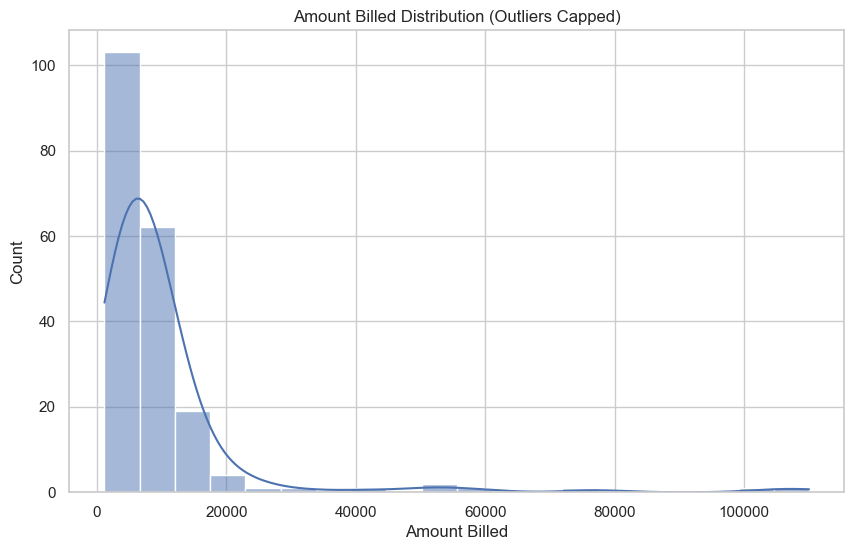

In [10]:
# Amount Billed distribution (post-outlier handling)
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount Billed'], bins=20, kde=True)
plt.title('Amount Billed Distribution (Outliers Capped)')
plt.xlabel('Amount Billed')
plt.ylabel('Count')
plt.show()

In [11]:
# use only rows with Amount Billed (we need a numeric amount to apply IQR)
df_label = df[df['Amount Billed'].notnull()].copy()

Q1 = df_label['Amount Billed'].quantile(0.25)
Q3 = df_label['Amount Billed'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

df_label['is_suspicious'] = (df_label['Amount Billed'] > threshold).astype(int)

print("Rows used for labeling:", df_label.shape[0])
print("IQR threshold:", threshold)
print(df_label['is_suspicious'].value_counts())


Rows used for labeling: 197
IQR threshold: 17600.0
is_suspicious
0    184
1     13
Name: count, dtype: int64


In [12]:
# dates -> length of stay
df_label['DATE OF ENCOUNTER'] = pd.to_datetime(df_label['DATE OF ENCOUNTER'], errors='coerce')
df_label['DATE OF DISCHARGE'] = pd.to_datetime(df_label['DATE OF DISCHARGE'], errors='coerce')
df_label['length_of_stay'] = (df_label['DATE OF DISCHARGE'] - df_label['DATE OF ENCOUNTER']).dt.days.fillna(0).astype(int)
df_label['length_of_stay'] = df_label['length_of_stay'].apply(lambda x: x if x >= 0 else 0)

In [13]:
# AGE imputation with median (simple)
df_label['AGE'] = df_label['AGE'].fillna(df_label['AGE'].median())

In [14]:
# DIAGNOSIS: frequency encoding (count per diagnosis) — simple way to summarize high-cardinality text
df_label['diag_freq'] = df_label['DIAGNOSIS'].map(df_label['DIAGNOSIS'].value_counts()).fillna(0)


In [15]:
# Gender: simple one-hot
df_label['GENDER'] = df_label['GENDER'].fillna('Unknown')
gender_dummies = pd.get_dummies(df_label['GENDER'], prefix='GENDER')


In [16]:
# Create dataframe of features:
# -- NOTE: If you created the label from Amount Billed, DO NOT include 'Amount Billed' in features (leakage).
features = ['AGE', 'length_of_stay', 'diag_freq']  # + gender dummies later
X = pd.concat([df_label[features].reset_index(drop=True), gender_dummies.reset_index(drop=True)], axis=1)
y = df_label['is_suspicious'].reset_index(drop=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30, stratify=y)


In [18]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [19]:
y_pred_rf = rf.predict(X_test)

In [20]:
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [21]:
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("RMSE :", root_mean_squared_error(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        47
           1       0.00      0.00      0.00         3

    accuracy                           0.94        50
   macro avg       0.47      0.50      0.48        50
weighted avg       0.88      0.94      0.91        50

Accuracy: 0.94
ROC AUC: 0.4787234042553191
RMSE : 0.2449489742783178


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Create some sample new data to test the model
new_data = pd.DataFrame({
    'AGE': [30, 55, 25, 45, 60],
    'length_of_stay': [1, 5, 0, 2, 10],
    'diag_freq': [10, 2, 15, 5, 1],
    'GENDER_F': [0, 1, 1, 0, 1],
    'GENDER_M': [1, 0, 0, 1, 0],
    'GENDER_Unknown': [0, 0, 0, 0, 0]
})

# Predict on the new data
new_predictions = rf.predict(new_data)
new_probabilities = rf.predict_proba(new_data)[:, 1]

print("Predictions on new data:", new_predictions)


Predictions on new data: [0 0 0 0 0]
